In [1]:
import pandas as pd
import numpy as np
from time import time
from config_loader import load
import argparse
import sys
import seaborn as sns
from MyDataUnderstanding import featureAnalysis
from MyPreprocessing import MyPreprocessing
import numpy as np
from time import time
import matplotlib.pyplot as plt
from model.models import models_perform
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from detect_outliers import detect_outliers

In [2]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGB
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from model.MyIBL import MyIBL as IBL
from sklearn.linear_model import LogisticRegression as LG

In [3]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

In [5]:
def getData(path, filenames_type):
    '''
    features_lst = [
        "Pclass", "Survived", "Name", "Sex", "Age",
        "Sibsp", "Parch", "Ticket", "Fare", "Cabin","Embarked",
        "Boat","Body","Home.dest"]
    '''
    if filenames_type == 'train':
        filename = 'train'
    elif filenames_type == 'test':
        filename = 'test'
    else:
        filename = 'titanicAll'
        
    df_features = pd.read_csv(path + filename + '.csv',
                           sep=',')

    if filenames_type not in ['train', 'test']:
        # drop unnecessary columns that don't exist in the official data
        df_features.drop(['Boat', 'Body', 'Home.dest'],
                           axis=1,
                           inplace=True)
    #labels = df_features['Survived']
    #df_features = df_features.drop(['Survived'], axis=1)
    return df_features

In [6]:
def runPreprocessing(process_type):
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "-c", "--config", default="titanic.cfg",
        help="specify the location of the clustering config file"
    )
    args, _ = parser.parse_known_args()

    config_file = args.config
    config = load(config_file)

    ##
    verbose = config.get('titanic', 'verbose')
    path = config.get('titanic', 'path') + '/'
    file_type = config.get('titanic', 'file_type')
    
    print(file_type)
    filename_type = 'train'
    if file_type == 'all':
        filename_type = 'other'

    trainData = getData(path, filename_type)
    
    # Preprocessing
    trainPreprocess = MyPreprocessing(process_type)

    ## test
    filename_type = 'test'
    testData = getData(path, filename_type)
    
    # Preprocessing
    testPreprocess = MyPreprocessing(process_type)
    trainPreprocess.fit(trainData)
    df_train = trainPreprocess.new_df
    # the labels "Survived"
    labels = trainPreprocess.labels_

    testPreprocess.fit(testData)
    df_test = testPreprocess.new_df
    labels_test = testPreprocess.labels_

    # fix missing columns because of NaNs and one hot encoding without dummy_na
    if df_train.shape[1] != df_test.shape[1]:
        missing_cols = set(df_test.columns) - set(df_train.columns)
        for col in missing_cols:
            #df_train[col] = np.zeros([df_train.shape[0], 1])
            df_test.drop([col], axis=1, inplace=True)

        missing_cols = set(df_train.columns) - set(df_test.columns)
        for col in missing_cols:
            #df_test[col] = np.zeros([df_test.shape[0], 1])
            df_train.drop([col], axis=1, inplace=True)
    return trainData, testData, df_train, labels, df_test, labels_test

In [7]:
def feature_importance(clf, df_train):
    if hasattr(clf, 'feature_importances_'):
        name = str(clf.__class__).split('.')[-1][:-2]
        feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
        feat_imp['feature'] = df_train.columns
        feat_imp.sort_values(by='importance', ascending=False, inplace=True)
        #feat_imp = feat_imp.iloc[:top_n]
        feat_imp.sort_values(by='importance', inplace=True)
        feat_imp = feat_imp.set_index('feature', drop=True)
        feat_imp.plot.barh(title='Feature Importance', figsize=(10,10))
        plt.xlabel('%s Feature Importance Score' %name)
        plt.show()
        return feat_imp
    return pd.DataFrame()

In [8]:
def ensemble(clf, x_train, y_train, x_test):
    
    name = str(clf.__class__).split('.')[-1][:-2]
    kf = KFold(n_splits=5)

    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]

    #ens_train = np.zeros((ntrain,))
    ens_train = np.array([])
    #ens_test = np.zeros((ntest,))
    #test_kf = np.empty((kf.n_folds, ntest))
    test_kf = np.zeros((kf.n_splits, ntest))
        
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        clf.fit(x_tr, y_tr)

        #ens_train[test_index] = clf.predict(x_te)
        ens_train = np.concatenate([ens_train, clf.predict(x_te)])
        # predict from the whole train set 
        #clf.fit(x_train,y_train)
        test_kf[i, :] = clf.predict(x_test)
    
    # features for next ensemble layer
    ens_train = pd.DataFrame(ens_train.reshape(-1,1), columns=[name])
    
    # combine for test
    ens_test = pd.DataFrame(test_kf.T).mode(axis=1)
    ens_test.columns = [name]
    
    return ens_train, ens_test

In [9]:
def modeler(clf, data, labels, train_fidx, validation_fidx):
    name = str(clf.__class__).split('.')[-1][:-2]
    print(name)
    folds_accuracy = list()
    duration = list()
    start = time()
    for idx, trf in enumerate(train_fidx):
        clf.fit(data.loc[trf], labels.loc[trf])
        prediction_labels = clf.predict(data.loc[validation_fidx[idx]])
        folds_accuracy.append(accuracy_score(labels.loc[validation_fidx[idx]], prediction_labels))
        
    mean_acc = mean(folds_accuracy)
    duration = time() - start
    print(name, mean_acc, "accuracy at validation stage,", duration, 's')
    df_folds_accuracy = pd.DataFrame([folds_accuracy], index=[name])
    df_folds = pd.DataFrame([[mean_acc, duration/len(train_fidx)]], columns=['Accuracy', 'Duration'], index=[name])
    return clf.fit(data, labels), df_folds, df_folds_accuracy

In [10]:
def get_cv_data(df_train, cv=5):
    kf = KFold(n_splits=cv)
    folds = [(train_idx, validation_idx) for train_idx, validation_idx in kf.split(df_train)]
    train_idx = [f[0] for f in folds]
    validation_idx = [f[1] for f in folds]
    return train_idx, validation_idx

In [11]:
def run_models(clfs, df_train, df_test, train_idx, validation_idx, cv=True, ens=True):
    models = []
    df_ens_features = pd.DataFrame()
    df_ens_test = pd.DataFrame()
    df_model_cvaccuracies = pd.DataFrame()
    df_model_info = pd.DataFrame()
    for clf in clfs:
        name = str(clf.__class__).split('.')[-1][:-2]
        
        # cross validation
        if cv:
            model, df_folds, df_folds_accuracy = modeler(clf, df_train, labels, train_idx, validation_idx)
            models.append(model)
            df_model_cvaccuracies = pd.concat([df_model_cvaccuracies, df_folds_accuracy], sort=False)
            df_model_info = pd.concat([df_model_info, df_folds], sort=False)  
            
            feature_importance(clf, df_train)
        
        # building ensemble
        if cv and ens:
            #df_feature = pd.DataFrame(cross_val_predict(clf, df_train, labels, cv=ens_kf).reshape(-1,1), columns=[name])
            df_ens_feature, ens_test = ensemble(clf, df_train, labels, df_test)
            df_ens_features = pd.concat([df_ens_features, df_ens_feature], axis=1, sort=False).reset_index(drop=True)
            df_ens_test = pd.concat([df_ens_test, ens_test], axis=1, sort=False).reset_index(drop=True)
            
    return models, df_model_cvaccuracies, df_model_info, df_ens_features, df_ens_test
        

In [12]:
def correlation_fig(df_ens_features):
    # calculate the correlation matrix
    corr = df_ens_features.corr()

    # plot the heatmap
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [13]:
clfs = [IBL(), RF(n_estimators =12), SVC(gamma='scale'), XGB(), MLP(max_iter=1000), KNN(), LDA()]
#clfs = [RF(n_estimators =12), SVC(gamma='scale'), XGB(), KNN(), LDA()]

# No Process

In [42]:
trainData, testData, df_train1, labels, df_test1, labels_test = runPreprocessing('noprocess')
df_train = df_train1
df_test = df_test1
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
noprocess
noprocess
(891, 12) (418, 12) (891,)
(891, 8) (418, 8)
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3'], dtype='object')


MyIBL
MyIBL 0.7216558910300671 accuracy at validation stage, 7.974684715270996 s
RandomForestClassifier
RandomForestClassifier 0.801362124160442 accuracy at validation stage, 0.08405947685241699 s


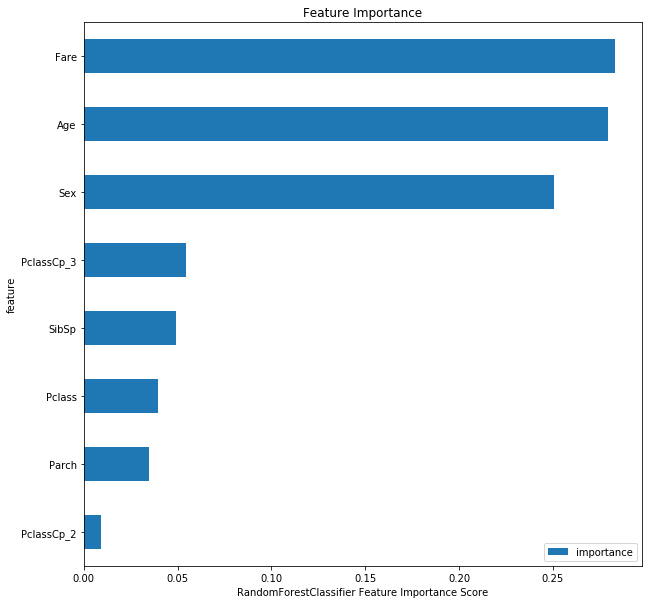

SVC
SVC 0.7923419747661792 accuracy at validation stage, 0.06804823875427246 s
XGBClassifier
XGBClassifier 0.8305316678174628 accuracy at validation stage, 0.283219575881958 s


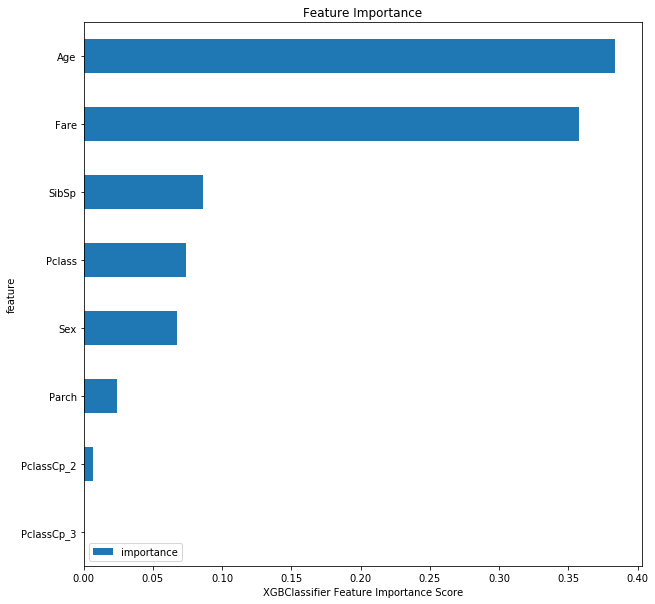

MLPClassifier
MLPClassifier 0.8069612704789404 accuracy at validation stage, 7.355356693267822 s
KNeighborsClassifier
KNeighborsClassifier 0.8182160567447115 accuracy at validation stage, 0.02601766586303711 s
LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.7878601468834349 accuracy at validation stage, 0.023029804229736328 s


In [28]:
models1, df_model_cvaccuracies1, df_model_info1, df_ens_features1, df_ens_test1 = run_models(clfs, df_train, df_test, train_idx, validation_idx, cv=True, ens=True)

In [29]:
for model in models1:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

MyIBL 0.69377990430622
RandomForestClassifier 0.7631578947368421
SVC 0.777511961722488
XGBClassifier 0.7607655502392344
MLPClassifier 0.7727272727272727
KNeighborsClassifier 0.7679425837320574
LinearDiscriminantAnalysis 0.7751196172248804


# Standard preprocess

In [43]:
trainData, testData, df_train2, labels, df_test2, labels_test = runPreprocessing('standard')
df_train = df_train2
df_test = df_test2
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
standard
standard
(891, 12) (418, 12) (891,)
(891, 24) (418, 24)
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X'], dtype='object')


MyIBL
MyIBL 0.7609566254472412 accuracy at validation stage, 6.628715515136719 s
RandomForestClassifier
RandomForestClassifier 0.7845458539953549 accuracy at validation stage, 0.08906388282775879 s


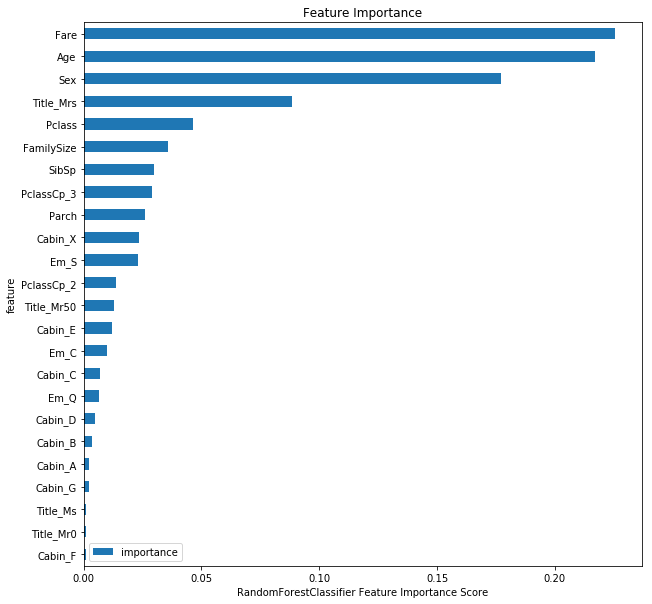

SVC
SVC 0.8226288368589543 accuracy at validation stage, 0.0980691909790039 s
XGBClassifier
XGBClassifier 0.8294143493817087 accuracy at validation stage, 0.5263724327087402 s


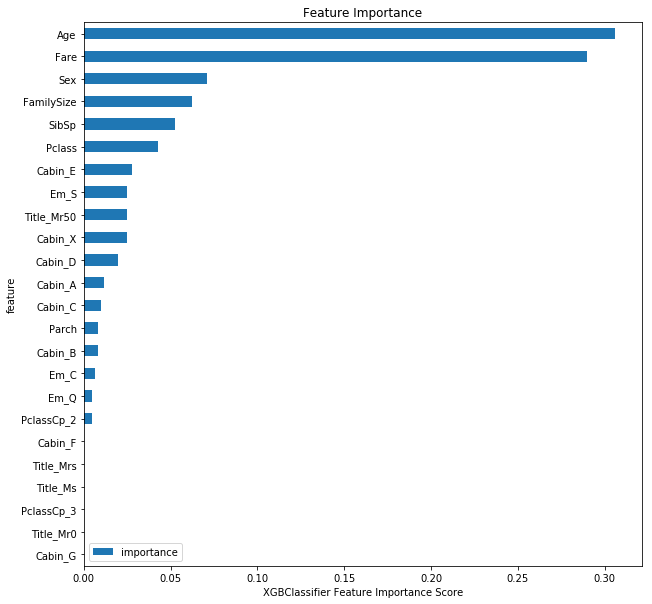

MLPClassifier
MLPClassifier 0.8159876969430669 accuracy at validation stage, 25.380027055740356 s
KNeighborsClassifier
KNeighborsClassifier 0.8024982738057874 accuracy at validation stage, 0.04903364181518555 s
LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8148138848785387 accuracy at validation stage, 0.08105850219726562 s


In [18]:
models2, df_model_cvaccuracies2, df_model_info2, df_ens_features2, df_ens_test2 = run_models(clfs, df_train, df_test, train_idx, validation_idx, cv=True, ens=True)

In [19]:
for model in models2:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

MyIBL 0.6818181818181818
RandomForestClassifier 0.7511961722488039
SVC 0.7942583732057417
XGBClassifier 0.7655502392344498
MLPClassifier 0.7727272727272727
KNeighborsClassifier 0.7583732057416268
LinearDiscriminantAnalysis 0.784688995215311


# Preprocessing with categories

In [44]:
trainData, testData, df_train3, labels, df_test3, labels_test = runPreprocessing('categorized')
df_train = df_train3
df_test = df_test3
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
categorized
categorized
(891, 12) (418, 12) (891,)
(891, 33) (418, 33)
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_Teenager', 'Age_bin_Adult', 'Family_bin_SmallFamily', 'Family_bin_BigFamily', 'Family_bin_Team', 'Fare_bin_Median', 'Fare_bin_Average', 'Fare_bin_High'], dtype='object')


MyIBL
MyIBL 0.7317996359299479 accuracy at validation stage, 8.902343034744263 s
RandomForestClassifier
RandomForestClassifier 0.8092084614901764 accuracy at validation stage, 0.09206557273864746 s


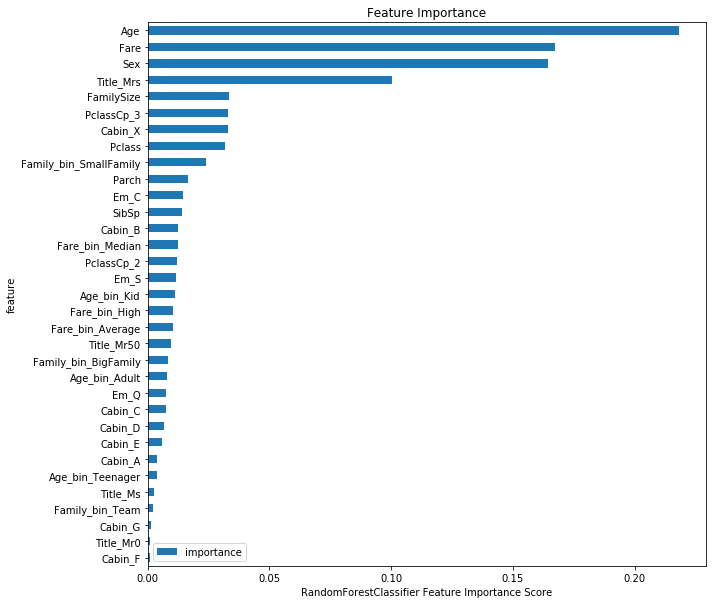

SVC
SVC 0.8338710689849979 accuracy at validation stage, 0.12308740615844727 s
XGBClassifier
XGBClassifier 0.8383905592869249 accuracy at validation stage, 0.671478271484375 s


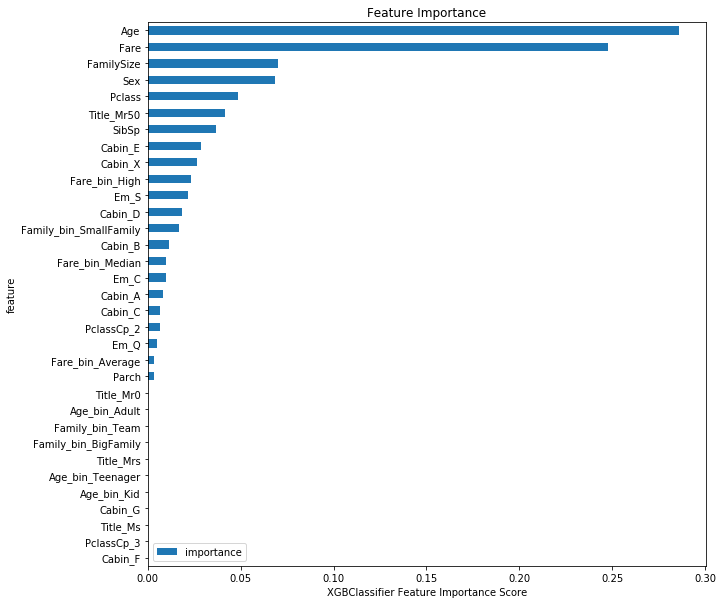

MLPClassifier
MLPClassifier 0.8181972255351202 accuracy at validation stage, 22.886335849761963 s
KNeighborsClassifier
KNeighborsClassifier 0.8204381394764924 accuracy at validation stage, 0.04304933547973633 s
LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8249136902893729 accuracy at validation stage, 0.07801270484924316 s


In [21]:
models3, df_model_cvaccuracies3, df_model_info3, df_ens_features3, df_ens_test3 = run_models(clfs, df_train, df_test, train_idx, validation_idx, cv=True, ens=True)

In [22]:
for model in models3:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

MyIBL 0.6698564593301436
RandomForestClassifier 0.7248803827751196
SVC 0.7799043062200957
XGBClassifier 0.7607655502392344
MLPClassifier 0.7703349282296651
KNeighborsClassifier 0.7703349282296651
LinearDiscriminantAnalysis 0.7655502392344498


# All the preprocessing

In [45]:
trainData, testData, df_train4, labels, df_test4, labels_test = runPreprocessing('all')
df_train = df_train4
df_test = df_test4
print(trainData.shape, testData.shape, labels.shape)
print(df_train.shape, df_test.shape)
print(df_train.columns)
train_idx, validation_idx = get_cv_data(df_train, cv=5)

traintest
all
all
(891, 12) (418, 12) (891,)
(891, 50) (418, 50)
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_Teenager', 'Age_bin_Adult', 'Family_bin_SmallFamily', 'Family_bin_BigFamily', 'Family_bin_Team', 'Fare_bin_Median', 'Fare_bin_Average', 'Fare_bin_High', 'Mother', 'Father', 'Daughter', 'Son', 'Orphan', 'RichWoman', 'MiddleClassWoman', 'PoorWoman', 'RichMan', 'MiddleClassMan', 'PoorMan', 'RichGirl', 'MiddleClassGirl', 'PoorGirl', 'RichBoy', 'MiddleClassBoy', 'PoorBoy'], dtype='object')


MyIBL
MyIBL 0.7408009541146193 accuracy at validation stage, 8.164822816848755 s
RandomForestClassifier
RandomForestClassifier 0.8103383340656581 accuracy at validation stage, 0.09508585929870605 s


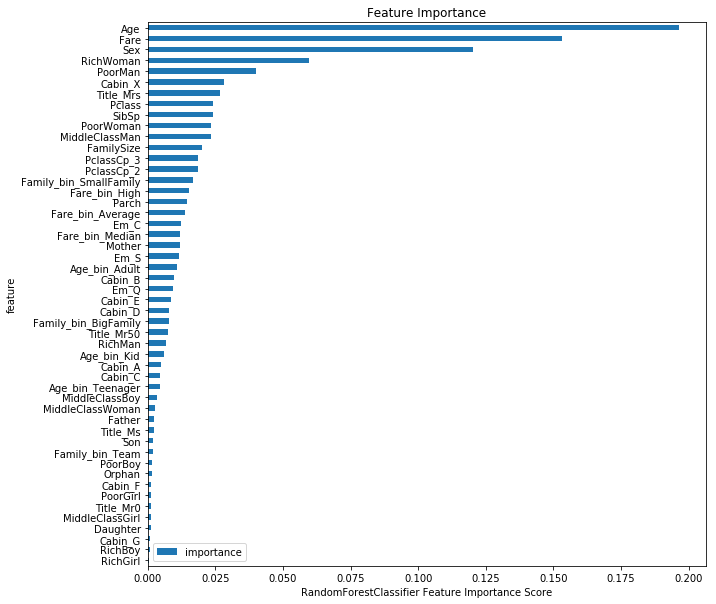

SVC
SVC 0.8316427091833533 accuracy at validation stage, 0.14710545539855957 s
XGBClassifier
XGBClassifier 0.8350260498399347 accuracy at validation stage, 0.9296808242797852 s


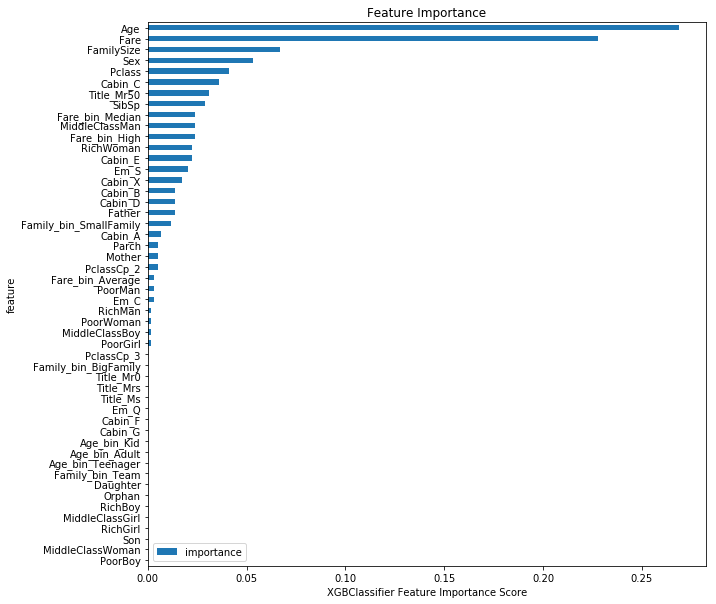

MLPClassifier
MLPClassifier 0.8148264390182662 accuracy at validation stage, 19.752825498580933 s
KNeighborsClassifier
KNeighborsClassifier 0.8226978846274559 accuracy at validation stage, 0.051035404205322266 s
LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.81483271608813 accuracy at validation stage, 0.09706902503967285 s


In [24]:
models4, df_model_cvaccuracies4, df_model_info4, df_ens_features4, df_ens_test4 = run_models(clfs, df_train, df_test, train_idx, validation_idx, cv=True, ens=True)

In [25]:
for model in models4:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

MyIBL 0.6985645933014354
RandomForestClassifier 0.7368421052631579
SVC 0.784688995215311
XGBClassifier 0.7679425837320574
MLPClassifier 0.7583732057416268
KNeighborsClassifier 0.7655502392344498
LinearDiscriminantAnalysis 0.7607655502392344


In [30]:
df_model_info1

,Accuracy,Duration
MyIBL,0.721656,1.594937
RandomForestClassifier,0.801362,0.016812
SVC,0.792342,0.013610
XGBClassifier,0.830532,0.056644
MLPClassifier,0.806961,1.471071
KNeighborsClassifier,0.818216,0.005204
LinearDiscriminantAnalysis,0.787860,0.004606


In [31]:
df_model_info2

,Accuracy,Duration
MyIBL,0.760957,1.325743
RandomForestClassifier,0.784546,0.017813
SVC,0.822629,0.019614
XGBClassifier,0.829414,0.105274
MLPClassifier,0.815988,5.076005
KNeighborsClassifier,0.802498,0.009807
LinearDiscriminantAnalysis,0.814814,0.016212


In [32]:
df_model_info3

,Accuracy,Duration
MyIBL,0.731800,1.780469
RandomForestClassifier,0.809208,0.018413
SVC,0.833871,0.024617
XGBClassifier,0.838391,0.134296
MLPClassifier,0.818197,4.577267
KNeighborsClassifier,0.820438,0.008610
LinearDiscriminantAnalysis,0.824914,0.015603


In [33]:
df_model_info4

,Accuracy,Duration
MyIBL,0.740801,1.632965
RandomForestClassifier,0.810338,0.019017
SVC,0.831643,0.029421
XGBClassifier,0.835026,0.185936
MLPClassifier,0.814826,3.950565
KNeighborsClassifier,0.822698,0.010207
LinearDiscriminantAnalysis,0.814833,0.019414


0.777511961722488

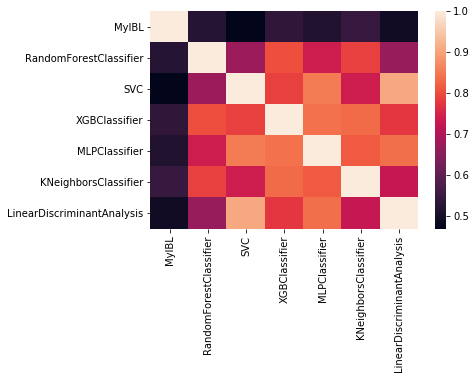

In [49]:
df_ens_features = df_ens_features1
df_ens_test = df_ens_test1
df_new_test = df_test1
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_test, labels_test)

0.7918660287081339

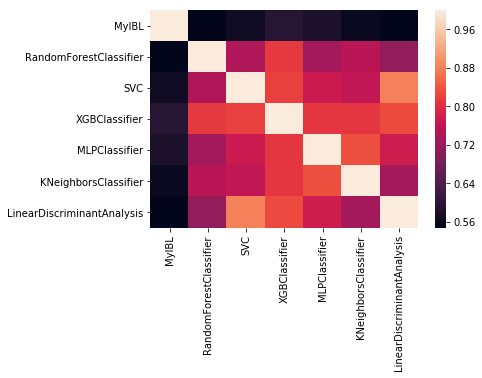

In [50]:
df_ens_features = df_ens_features2
df_ens_test = df_ens_test2
df_new_test = df_test2
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_test, labels_test)

0.784688995215311

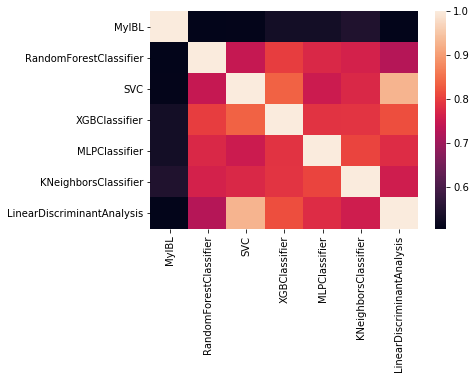

In [188]:
df_ens_features = df_ens_features3
df_ens_test = df_ens_test3
df_new_test = df_test3
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'XGBClassifier', 'SVC']]
df_test = df_ens_test[['MyIBL', 'XGBClassifier', 'SVC']]
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_test, labels_test)

0.7822966507177034

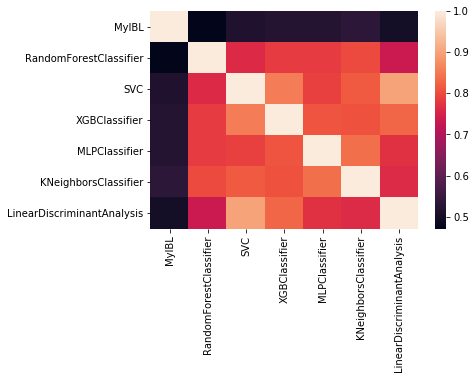

In [192]:
df_ens_features = df_ens_features4
df_ens_test = df_ens_test4
df_new_test = df_test4
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_test = df_ens_test[['MyIBL', 'SVC']]
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_test, labels_test)

In [ ]:
df_ens_features.columns, df_ens_features.shape

In [ ]:
df_ens_test.columns, df_ens_test.shape

In [ ]:
df_ens = df_ens_features[['MyIBL','SVC']]
df_new_test = df_ens_test[['MyIBL', 'SVC']]

In [ ]:
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_new_test, labels_test)

In [ ]:
for model in models:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(df_train, labels)
#model = SelectFromModel(lsvc, prefit=True)
model = SelectFromModel(RF(n_estimators=100, random_state=101), threshold='median')
model.fit(df_train, labels)
train_new = model.transform(df_train)
feature_idx = model.get_support()
df_train_fs = pd.DataFrame(train_new, columns=df_train.columns[feature_idx])
test_new = model.transform(df_test)
df_test_fs = pd.DataFrame(test_new, columns=df_test.columns[feature_idx])
df_test_fs.shape

In [ ]:
clfs = [IBL(), RF(n_estimators =12), SVC(gamma='scale'), XGB(), MLP(max_iter=10000), KNN(), LDA()]

In [ ]:
models, df_model_cvaccuracies, df_model_info, df_ens_features, df_ens_test = run_models(clfs, df_train_fs, df_test_fs, train_idx, validation_idx, cv=True, ens=True)

In [ ]:
for model in models:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test_fs)))

In [41]:
df_ens_features = df_ens_features1
df_new_test = df_new_test1
correlation_fig(df_ens_features)
df_ens_features.columns
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_new_test = df_ens_test[['MyIBL', 'SVC']]
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_new_test, labels_test)

NameError: name 'df_new_test1' is not defined

In [193]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
def significance_test(df_model_cvaccuracies):
    accum_acc_lst = df_model_cvaccuracies.values

    print("Friedman test on 'accuracy'")
    stat, p = friedmanchisquare(*accum_acc_lst)
    print(stat, p)
    a = 0.05
    if p < a:
        row_names = df_model_cvaccuracies.index.tolist()

        res = sp.posthoc_nemenyi_friedman(accum_acc_lst.T)
        res = res.rename(columns={i:row_names[i] for i in res.columns},
                         index={i:row_names[i] for i in res.columns})
        plt.figure(1)
        cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
        heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        sp.sign_plot(res, **heatmap_args)
        plt.title('Nemenyi p-values matrix')

        plt.figure(2, (10,10))
        for acc, row in zip(accum_acc_lst, row_names):
            # Subset to the airline

            # Draw the density plot
            sns.distplot(acc, hist = False, kde = True,
                        kde_kws = {'linewidth': 3},
                        label = row)

        # Plot formatting
        plt.legend(prop={'size': 16}, title = 'Model')
        plt.title('Density Plot with Multiple Models')
        plt.xlabel('Accuracy')
        plt.ylabel('Density')

    plt.show()

Friedman test on 'accuracy'
20.899628252788098 0.001912363452802991


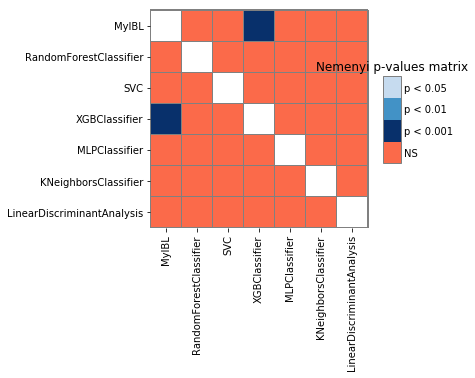

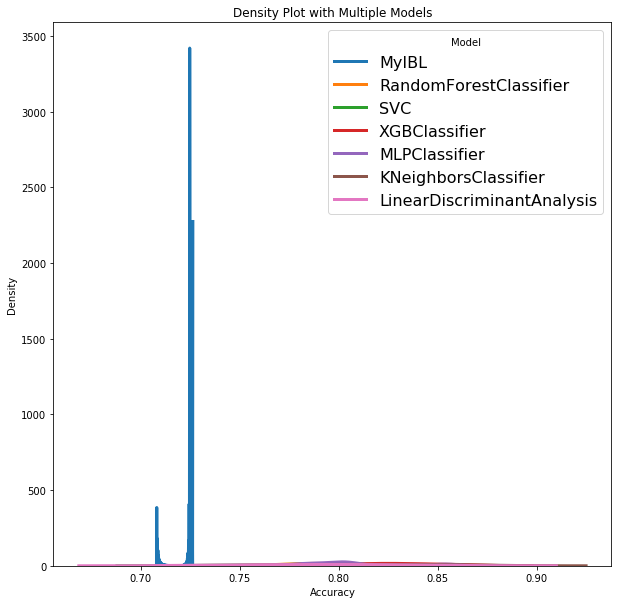

In [194]:
significance_test(df_model_cvaccuracies1)

Friedman test on 'accuracy'
16.42446043165467 0.01164825448266237


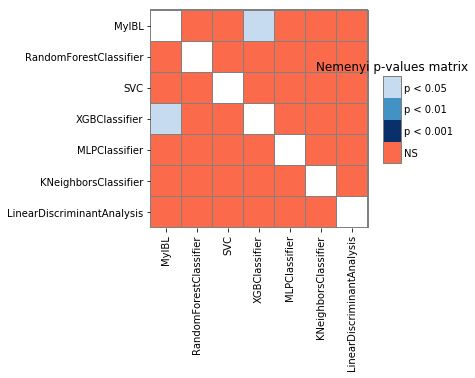

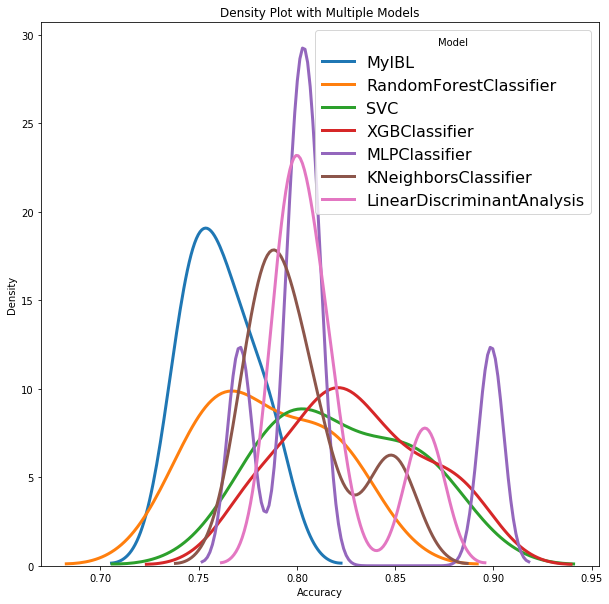

In [195]:
significance_test(df_model_cvaccuracies2)

Friedman test on 'accuracy'
16.580645161290324 0.010954513840974177


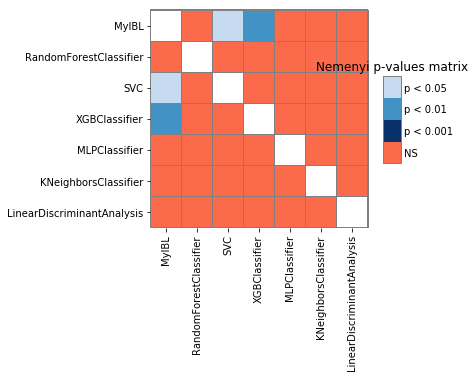

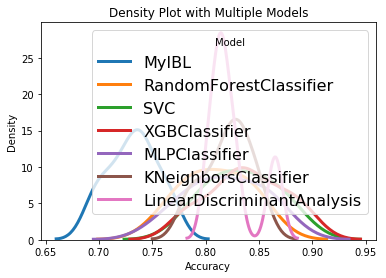

In [185]:
significance_test(df_model_cvaccuracies3)

Friedman test on 'accuracy'
15.917910447761203 0.014201423276309615


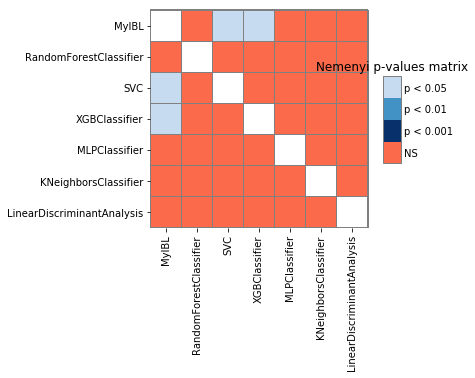

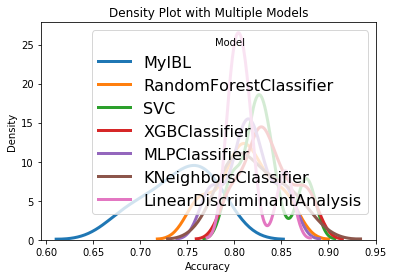

In [186]:
significance_test(df_model_cvaccuracies4)

In [177]:
df_train = df_train4.copy()
df_test = df_test4.copy()
labels_tmp = labels.copy()
df_train.shape

(891, 50)

In [178]:
from detect_outliers import detect_outliers
Outliers_to_drop = detect_outliers(df_train,19,df_train.columns)
len(Outliers_to_drop) # these can be removed

0

In [179]:
df_train.drop(Outliers_to_drop, inplace=True)
labels_tmp.drop(Outliers_to_drop, inplace=True)
df_train.shape

(891, 50)

In [181]:
clf=SVC()
clf.fit(df_train, labels_tmp)
clf.score(df_test,labels_test)

0.7918660287081339

In [226]:
df = pd.concat([df_model_info1.Accuracy, df_model_info2.Accuracy, df_model_info3.Accuracy, df_model_info4.Accuracy], axis=1)
df.columns = [df_train1.shape[1], df_train2.shape[1], df_train3.shape[1], df_train4.shape[1]]

In [229]:
df

,8,24,33,50
MyIBL,0.701656,0.740957,0.711800,0.740801
RandomForestClassifier,0.781362,0.764546,0.789208,0.810338
SVC,0.772342,0.802629,0.813871,0.831643
XGBClassifier,0.810532,0.809414,0.818391,0.835026
MLPClassifier,0.786961,0.795988,0.798197,0.814826
KNeighborsClassifier,0.798216,0.782498,0.800438,0.822698
LinearDiscriminantAnalysis,0.767860,0.794814,0.804914,0.814833


array([1, 3, 3, 3, 3, 3, 3], dtype=int64)

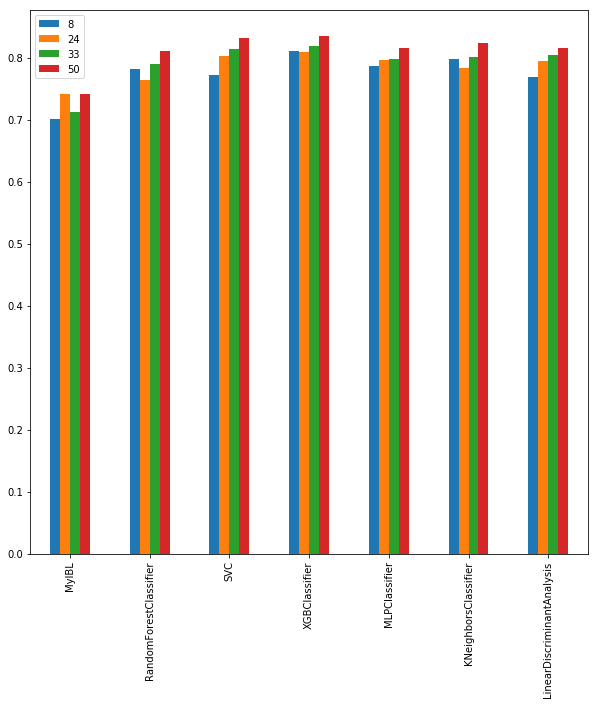

In [230]:
df.plot.bar(figsize=(10,10))
df.values.argmax(axis=1)